#**GVAMT-Lite: Multimodal VAE–GRU model on MNIST with textual digit captions.**

This notebook implements a practical, resource-friendly subset of the GVAMT
architecture proposed in:

    Pradeep L. et al. (2024).
    "Multimodal Integration in Large Language Models: Advancing AI With
    Generative Adversarial Networks, Variational Autoencoders, and
    Transformers (GVAMT-Model)", IJARESM.

The goal is to provide an end-to-end, executable prototype that:

  * Encodes images via a VAE encoder,
  * Encodes digit captions via a GRU-based text encoder,
  * Fuses both modalities in a shared latent space,
  * Reconstructs the image and generates the caption jointly.

All components are intentionally lightweight so that the model can be trained
on Google Colab with limited compute.


In [1]:
import time
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# ---------------------------
# Vocabulary and token indices
# ---------------------------

digit_words = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine",
}

special_tokens = ["<pad>", "<sos>", "<eos>"]
word_list = special_tokens + sorted(set(digit_words.values()))
word2idx = {w: i for i, w in enumerate(word_list)}
idx2word = {i: w for w, i in word2idx.items()}

PAD_IDX = word2idx["<pad>"]
SOS_IDX = word2idx["<sos>"]
EOS_IDX = word2idx["<eos>"]

vocab_size = len(word2idx)
print("Vocab size:", vocab_size, word2idx)


class MNISTWithText(Dataset):
    """MNIST digits paired with synthetic textual captions.

    Each sample consists of:
      * a grayscale image x ∈ [0, 1]^{1×28×28},
      * a caption y in tokenized form, e.g. "<sos> seven <eos>".

    The text is intentionally simple to isolate the multimodal fusion aspect
    while keeping the language modeling lightweight and computationally cheap.
    """

    def __init__(self, train: bool = True) -> None:
        """Initializes the multimodal MNIST–text dataset.

        Parameters
        ----------
        train : bool, optional
            If True, load the training split; otherwise load the test split.
        """
        transform = transforms.Compose([
            transforms.ToTensor(),  # (1, 28, 28), values in [0, 1]
        ])
        self.mnist = datasets.MNIST(
            root="./data",
            train=train,
            transform=transform,
            download=True,
        )

    def __len__(self) -> int:
        """Returns the number of available samples."""
        return len(self.mnist)

    @staticmethod
    def encode_caption(label: int) -> torch.Tensor:
        """Encodes a digit label as a caption token sequence.

        The mapping follows the global dictionary `digit_words` and wraps
        each word with <sos> and <eos> markers:

            label = 7 → "seven" → [<sos>, "seven", <eos>].

        Parameters
        ----------
        label : int
            Integer digit in {0, …, 9}.

        Returns
        -------
        torch.Tensor
            1-D tensor of token indices with length 3 and dtype long.
        """
        word = digit_words[int(label)]
        tokens = [SOS_IDX, word2idx[word], EOS_IDX]
        return torch.tensor(tokens, dtype=torch.long)

    def __getitem__(self, idx: int):
        """Retrieves a single multimodal example.

        Parameters
        ----------
        idx : int
            Index of the requested sample.

        Returns
        -------
        img : torch.Tensor
            Tensor of shape (1, 28, 28) with values in [0, 1].
        caption_tokens : torch.Tensor
            1-D tensor of caption token IDs.
        label : int
            Integer digit label in {0, …, 9}.
        """
        img, label = self.mnist[idx]
        caption_tokens = self.encode_caption(label)
        return img, caption_tokens, label


def collate_fn(batch: List[Tuple[torch.Tensor, torch.Tensor, int]]):
    """Collates a batch of variable-length captions.

    This function:
      1. Stacks image tensors,
      2. Pads caption sequences to the max length in the batch,
      3. Returns caption lengths for use with packed RNNs.

    Parameters
    ----------
    batch : list of tuples
        Each element is (img, caption_tokens, label) as returned by
        `MNISTWithText.__getitem__`.

    Returns
    -------
    imgs : torch.Tensor
        Tensor of shape (B, 1, 28, 28).
    padded : torch.Tensor
        Long tensor of shape (B, L_max) containing token IDs, padded with PAD_IDX.
    lengths : torch.Tensor
        1-D tensor of shape (B,) with true caption lengths.
    labels : torch.Tensor
        1-D tensor of shape (B,) with digit labels.
    """
    imgs, labels, captions, lengths = [], [], [], []
    for img, cap, lab in batch:
        imgs.append(img)
        labels.append(lab)
        captions.append(cap)
        lengths.append(len(cap))

    max_len = max(lengths)
    padded = torch.full((len(batch), max_len), PAD_IDX, dtype=torch.long)
    for i, cap in enumerate(captions):
        padded[i, :len(cap)] = cap

    imgs = torch.stack(imgs, dim=0)
    labels = torch.tensor(labels, dtype=torch.long)
    lengths = torch.tensor(lengths, dtype=torch.long)

    return imgs, padded, lengths, labels

Vocab size: 13 {'<pad>': 0, '<sos>': 1, '<eos>': 2, 'eight': 3, 'five': 4, 'four': 5, 'nine': 6, 'one': 7, 'seven': 8, 'six': 9, 'three': 10, 'two': 11, 'zero': 12}


In [3]:
batch_size = 128

train_ds = MNISTWithText(train=True)
test_ds = MNISTWithText(train=False)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
)

len(train_ds), len(test_ds)

(60000, 10000)

In [4]:
class ImageVAEEncoder(nn.Module):
    """Convolutional encoder for the image branch of GVAMT-Lite.

    Maps an input image x ∈ [0, 1]^{1×28×28} to the parameters of a Gaussian
    latent distribution N(μ, Σ), where Σ is diagonal.
    """

    def __init__(self, latent_dim: int = 64) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # → (B,32,14,14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # → (B,64,7,7)
            nn.ReLU(),
        )
        self.flat_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flat_dim, latent_dim)

    def forward(self, x: torch.Tensor):
        """Encodes a batch of images into latent distribution parameters.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor of shape (B, 1, 28, 28).

        Returns
        -------
        mu : torch.Tensor
            Mean of the approximate posterior, shape (B, latent_dim).
        logvar : torch.Tensor
            Log-variance of the approximate posterior, shape (B, latent_dim).
        """
        h = self.conv(x)                  # (B,64,7,7)
        h = h.view(x.size(0), -1)         # (B, flat_dim)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar


class ImageVAEDecoder(nn.Module):
    """Deconvolutional decoder for reconstructing images from fused latents."""

    def __init__(self, latent_dim: int = 64) -> None:
        super().__init__()
        self.flat_dim = 64 * 7 * 7
        self.fc = nn.Linear(latent_dim, self.flat_dim)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # → (B,32,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # → (B,1,28,28)
            nn.Sigmoid(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Decodes a batch of latent vectors into reconstructed images.

        Parameters
        ----------
        z : torch.Tensor
            Latent tensor of shape (B, latent_dim).

        Returns
        -------
        torch.Tensor
            Reconstructed images of shape (B, 1, 28, 28).
        """
        h = self.fc(z)                    # (B, flat_dim)
        h = h.view(z.size(0), 64, 7, 7)   # (B,64,7,7)
        x_recon = self.deconv(h)          # (B,1,28,28)
        return x_recon


class TextEncoder(nn.Module):
    """GRU-based encoder for digit captions."""

    def __init__(self, vocab_size: int, embed_dim: int = 32, hidden_dim: int = 64) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.hidden_dim = hidden_dim

    def forward(self, captions: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        """Encodes a batch of captions into fixed-size vectors.

        Parameters
        ----------
        captions : torch.Tensor
            Integer tensor of token IDs with shape (B, L).
        lengths : torch.Tensor
            1-D tensor of caption lengths, shape (B,).

        Returns
        -------
        torch.Tensor
            Sentence representations of shape (B, hidden_dim).
        """
        emb = self.embed(captions)  # (B,L,E)
        packed = nn.utils.rnn.pack_padded_sequence(
            emb, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        _, h_n = self.gru(packed)   # h_n: (1,B,H)
        return h_n.squeeze(0)       # (B,H)


class TextDecoder(nn.Module):
    """GRU-based conditional decoder for caption generation."""

    def __init__(self, vocab_size: int, embed_dim: int = 32, hidden_dim: int = 64) -> None:
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=PAD_IDX)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, captions_in: torch.Tensor, hidden: torch.Tensor):
        """Performs a teacher-forced decoding pass.

        Parameters
        ----------
        captions_in : torch.Tensor
            Input token IDs (excluding final <eos>), shape (B, L_in).
        hidden : torch.Tensor
            Initial hidden state, typically the fused latent, shape (B, H).

        Returns
        -------
        logits : torch.Tensor
            Unnormalized token scores of shape (B, L_in, vocab_size).
        final_hidden : torch.Tensor
            Final GRU hidden state of shape (B, H).
        """
        emb = self.embed(captions_in)            # (B,L_in,E)
        output, h_n = self.gru(emb, hidden.unsqueeze(0))
        logits = self.fc_out(output)             # (B,L_in,V)
        return logits, h_n.squeeze(0)

In [5]:
class GVAMTLite(nn.Module):
    """GVAMT-Lite: a lightweight multimodal generative model.

    Combines:
      * Image VAE encoder/decoder,
      * GRU text encoder/decoder,
      * Early fusion of image + text latents into a shared representation.
    """

    def __init__(
        self,
        vocab_size: int,
        img_latent_dim: int = 64,
        txt_hidden_dim: int = 64,
        fused_dim: int = 64,
    ) -> None:
        super().__init__()
        self.img_encoder = ImageVAEEncoder(latent_dim=img_latent_dim)
        self.img_decoder = ImageVAEDecoder(latent_dim=fused_dim)

        self.txt_encoder = TextEncoder(
            vocab_size=vocab_size, embed_dim=32, hidden_dim=txt_hidden_dim
        )
        self.txt_decoder = TextDecoder(
            vocab_size=vocab_size, embed_dim=32, hidden_dim=fused_dim
        )

        self.fusion = nn.Linear(img_latent_dim + txt_hidden_dim, fused_dim)

    @staticmethod
    def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        """Applies the standard VAE reparameterization trick."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, imgs: torch.Tensor, captions: torch.Tensor, lengths: torch.Tensor):
        """Runs a full forward pass of GVAMT-Lite.

        Returns image reconstructions and token logits suitable for
        computing the composite loss.
        """
        # Image branch
        mu, logvar = self.img_encoder(imgs)
        z_img = self.reparameterize(mu, logvar)

        # Text branch
        z_txt = self.txt_encoder(captions, lengths)

        # Early fusion
        fused_input = torch.cat([z_img, z_txt], dim=1)
        fused_z = self.fusion(fused_input)

        # Image reconstruction
        img_recon = self.img_decoder(fused_z)

        # Text decoding with teacher forcing
        captions_in = captions[:, :-1]
        captions_tgt = captions[:, 1:]
        logits, _ = self.txt_decoder(captions_in, fused_z)

        return img_recon, mu, logvar, logits, captions_tgt


def multimodal_loss(
    imgs: torch.Tensor,
    img_recon: torch.Tensor,
    mu: torch.Tensor,
    logvar: torch.Tensor,
    logits: torch.Tensor,
    captions_tgt: torch.Tensor,
    lengths: torch.Tensor,
    alpha_img: float = 1.0,
    beta_kl: float = 1e-3,
    gamma_txt: float = 1.0,
):
    """Composite objective: image recon + KL + text cross-entropy."""
    # Image reconstruction
    recon_loss = F.binary_cross_entropy(img_recon, imgs, reduction="sum")

    # KL divergence between q(z|x) and N(0, I)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Text cross-entropy (flatten)
    B, Lm1, V = logits.shape
    logits_flat = logits.reshape(B * Lm1, V)
    tgt_flat = captions_tgt.reshape(B * Lm1)

    txt_loss = F.cross_entropy(
        logits_flat, tgt_flat, ignore_index=PAD_IDX, reduction="sum"
    )

    total = alpha_img * recon_loss + beta_kl * kl + gamma_txt * txt_loss
    return total, recon_loss, kl, txt_loss

In [6]:
model = GVAMTLite(
    vocab_size=vocab_size,
    img_latent_dim=64,
    txt_hidden_dim=64,
    fused_dim=64,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epochs: int = 5,
) -> None:
    """Trains GVAMT-Lite for a given number of epochs.

    Parameters
    ----------
    model : nn.Module
        GVAMTLite instance.
    loader : DataLoader
        Training dataloader.
    optimizer : torch.optim.Optimizer
        Optimization algorithm.
    device : torch.device
        CPU or CUDA device.
    epochs : int, optional
        Number of full passes over the training set.
    """
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = total_recon = total_kl = total_txt = 0.0
        n_samples = 0
        t0 = time.time()

        for imgs, captions, lengths, labels in loader:
            imgs = imgs.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)

            optimizer.zero_grad()
            img_recon, mu, logvar, logits, captions_tgt = model(
                imgs, captions, lengths
            )

            loss, recon, kl, txt = multimodal_loss(
                imgs, img_recon, mu, logvar, logits, captions_tgt, lengths
            )

            loss.backward()
            optimizer.step()

            batch_size = imgs.size(0)
            n_samples += batch_size
            total_loss += loss.item()
            total_recon += recon.item()
            total_kl += kl.item()
            total_txt += txt.item()

        dt = time.time() - t0
        print(
            f"Epoch {epoch}/{epochs} | "
            f"Loss: {total_loss/n_samples:.4f} | "
            f"Recon: {total_recon/n_samples:.4f} | "
            f"KL: {total_kl/n_samples:.4f} | "
            f"Text: {total_txt/n_samples:.4f} | "
            f"Time: {dt:.1f}s"
        )


train(model, train_loader, optimizer, device, epochs=5)

Epoch 1/5 | Loss: 118.7941 | Recon: 117.4002 | KL: 588.6555 | Text: 0.8053 | Time: 11.3s
Epoch 2/5 | Loss: 63.7682 | Recon: 63.1771 | KL: 482.9101 | Text: 0.1082 | Time: 10.8s
Epoch 3/5 | Loss: 58.9570 | Recon: 58.5184 | KL: 385.9859 | Text: 0.0527 | Time: 10.7s
Epoch 4/5 | Loss: 56.8739 | Recon: 56.5022 | KL: 343.7999 | Text: 0.0279 | Time: 10.9s
Epoch 5/5 | Loss: 55.6377 | Recon: 55.2999 | KL: 321.5235 | Text: 0.0163 | Time: 10.8s


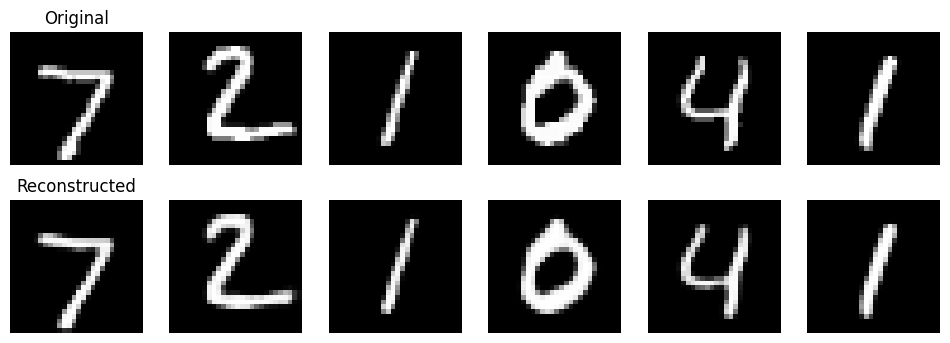

Label: 7 | True text: seven | Generated text: seven


In [7]:
def decode_caption_from_latent(
    model: GVAMTLite,
    fused_z: torch.Tensor,
    max_len: int = 5,
) -> str:
    """Greedy decoding of a caption from a fused latent vector.

    Starts from the <sos> token and iteratively selects the highest-probability
    token at each time step until <eos> is produced or max_len is reached.
    """
    model.eval()
    with torch.no_grad():
        B = fused_z.size(0)
        hidden = fused_z.unsqueeze(0)  # (1,B,H)

        input_token = torch.full(
            (B, 1), SOS_IDX, dtype=torch.long, device=device
        )
        generated = []

        for _ in range(max_len):
            emb = model.txt_decoder.embed(input_token)
            output, hidden = model.txt_decoder.gru(emb, hidden)
            logits = model.txt_decoder.fc_out(output)  # (B,1,V)
            token = logits.argmax(dim=-1)              # (B,1)
            generated.append(token)
            input_token = token

        generated = torch.cat(generated, dim=1)  # (B, max_len)

    tokens = generated[0].cpu().tolist()
    words = []
    for t in tokens:
        if t == EOS_IDX:
            break
        if t in idx2word and t not in (PAD_IDX, SOS_IDX, EOS_IDX):
            words.append(idx2word[t])
    return " ".join(words) if words else "<empty>"


def show_samples(
    model: GVAMTLite,
    loader: DataLoader,
    device: torch.device,
    n: int = 6,
) -> None:
    """Visualizes original vs reconstructed images and prints a sample caption.

    Parameters
    ----------
    model : GVAMTLite
        Trained model.
    loader : DataLoader
        Dataloader (typically the test split).
    device : torch.device
        Execution device.
    n : int, optional
        Number of image pairs to show.
    """
    model.eval()
    imgs, captions, lengths, labels = next(iter(loader))
    imgs = imgs.to(device)
    captions = captions.to(device)
    lengths = lengths.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        mu, logvar = model.img_encoder(imgs)
        z_img = model.reparameterize(mu, logvar)
        z_txt = model.txt_encoder(captions, lengths)
        fused_input = torch.cat([z_img, z_txt], dim=1)
        fused_z = model.fusion(fused_input)
        img_recon = model.img_decoder(fused_z)

    imgs_np = imgs.cpu().numpy()
    recon_np = img_recon.cpu().numpy()

    plt.figure(figsize=(2 * n, 4))
    for i in range(n):
        # original
        plt.subplot(2, n, i + 1)
        plt.imshow(imgs_np[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # reconstructed
        plt.subplot(2, n, n + i + 1)
        plt.imshow(recon_np[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstructed")

    plt.show()

    decoded = decode_caption_from_latent(model, fused_z[:1], max_len=3)
    true_word = digit_words[int(labels[0].item())]
    print(
        f"Label: {labels[0].item()} | True text: {true_word} | "
        f"Generated text: {decoded}"
    )


show_samples(model, test_loader, device, n=6)